In [1]:
import pandas as pd 
import numpy as np
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 
import re
import collections
import operator
import os
import pickle
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import doc2vec
from collections import namedtuple
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import model_selection
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# 1.Data-preprocesssing, exclude special character / space / number 

In [85]:
# Pre-process file, set exclude_digit = True if do not include digit 
def pre_process(file_content, exclude_digit = False):
    
    processed_article = file_content.lower()
    
    # Decide whether to exclude the digit or not 
    if exclude_digit is False:
    
        # Include digit
        processed_article = re.sub(',', '', processed_article )
        processed_article = re.sub('[^a-zA-Z0-9]', ' ', processed_article )
    else: 
        # Exclude digit
        processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )

    processed_article = re.sub(r'\s+', ' ', processed_article)
    
    
    return processed_article

# 2. Using stop words list to reduce content and Exclude word length < 4

In [86]:
def Exclude_by_Stop_words (processed_article, stop_words_list):
    all_sentences = nltk.sent_tokenize(processed_article)
    
    if len(all_sentences) == 1:
        all_words = nltk.word_tokenize(all_sentences[0])
#         print('There are',len(all_words),'words.')
        
        all_words = [word for word in all_words if len(word) >4 ]
#         print('There are',len(all_words),'has more than 4 characters.')

        all_words = [word for word in all_words if word not in stop_words_list]
#         print('There are',len(all_words),'after removed stop_words.\n')
        
        return all_words
    
    else:
        print('Length > 1.')

# 3. Using IQR to remove outliers from our target y (adjust_stock prices)

In [7]:
# dataframe = data include 10k_file_name and adjusted stock prices
# column_name = adjusted stock prices
# outlierConstant = default is 5, you can change it if you want

def remove_Outliers(dataframe, column_name, outlierConstant = 5):
    a = np.array(dataframe[column_name])
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    index_list = []
    for i in range(0,len(a)):
        value = a[i]
        if value <= quartileSet[0] or value >= quartileSet[1]:
            index_list.append(i)
            
    new_dataframe = dataframe[~dataframe.index.isin(index_list)].reset_index(drop = True)
    
    print('upper_quartile is',round(upper_quartile,3))
    print('lower_quartile is',round(lower_quartile,3))
    print('IQR is',round(IQR,3))
    print('quartileSet is',quartileSet)
    print('dataset size:', len(a))
    print('Number of outliers:',len(index_list),'\n')

    return new_dataframe

# 4. Using Exclude_Stop_words function to create a list of content for all 10K files in the file

In [88]:
# Remove words by new stop_words_list

# folder_path = folder that contain the 10k files
# file_name_list = list of 10k files that have adjusted stock prices

def list_content_for_model(folder_path = None,file_name_list = None):
#     file_name_1996 = os.listdir('/Users/jinbinliang/Desktop/ISE599/Project/10K/2004.full')
    stop_words_list = []
    list_10k_contents = []
    
    # replace file_path to your stop words location
    with open("/Users/jinbinliang/Desktop/ISE599/Project/10K/stop_word.txt", "r") as f:
        for line in f:
            stop_words_list.append(str(line.strip()))

    Num_doc = len(file_name_list)
    count = 1
    for file_name in file_name_list:
#         file_name = file_name_1996[i]
        file_path = folder_path + file_name
        f = open(file_path,'r')
        pre_processed_article = f.read()[3000:]
        f.close()
        processed_article = pre_process(pre_processed_article)
        Exclude_word_processed_article = Exclude_by_Stop_words(processed_article,stop_words_list)
        list_10k_contents.append(Exclude_word_processed_article)
        print(count,'/',Num_doc,'completed')
        count += 1
    return list_10k_contents

# 5. Build a doc_model to compute all of 10K files' vector.

In [117]:
# list_10k_contents = 10k file contents
# vector_size = number of vector for each docs

def doc_model(list_10k_contents, vector_size = 30, window = 300, min_count = 2):
    docs = []
    analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
    for i, text in enumerate(list_10k_contents):
        tags = [i]
        docs.append(analyzedDocument(text, tags))
    
    model = doc2vec.Doc2Vec(docs, size = vector_size, window = window, min_count = min_count, workers = 4)
    return model 

In [120]:
def construct_X(doc_vectors):
    x = []
    
    for vector in range(0,len(doc_vectors.docvecs)):
        x.append(list(doc_vectors[vector]))
    
    return x

# 6. Build regression model

In [90]:
# Separate train and test set 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

NameError: name 'X' is not defined

In [91]:
def model(X,y, model_name = 'linear'):
    
    if model_name == linear:
        model = LinearRegression().fit(X, y)
    if model_name == ridge:
        model = linear_model.Ridge(alpha=.5).fit(X, y)
    if model_name == lasso:
        model = linear_model.Lasso(alpha=0.1).fit(X, y)
    if model_name == tree:
        model = DecisionTreeRegressor(random_state=0)
        
    return model

In [92]:
def evaluation_model(model, x_train, y_train, x_test, y_test):
    
    cv_mse = cross_val_score(reg,x_train, y_train, cv=10, scoring='neg_mean_squared_error' )
    cv_mbe = cross_val_score(reg,x_train, y_train, cv=10, scoring='neg_mean_absolute_error' )
    cv_r2 = cross_val_score(reg,x_train, y_train, cv=10, scoring='r2' )
    print('CV mse is',round(np.mean(cv_mse),4))
    print('CV mbe is',round(np.mean(cv_mbe),4))
    print('CV R^2 is',round(np.mean(cv_r2),4),'\n')
    
    y_pred = model.predict(x_test)
    test_mse = mean_squared_error(y_test, y_pred)
    print('Test mse is',round(test_mse,4))

# Code process

In [95]:
input_file_path = "/Users/jinbinliang/Desktop/ISE599/Project/CIK_Stock_price/2001_10k_2002_price.csv"

d1 = pd.read_csv(input_file_path)
d1.head(2)

,Unnamed: 0,filename,CENTRAL INDEX KEY:,symbol,year,close_adjusted
0,0,74762E102-10-K-20010402.txt,1050915,1050915,2002,8.728929
1,1,206710204-10-K-2001-09-19.txt,749038,749038,2002,36.256077


In [96]:
d2 = remove_Outliers(d1,'close_adjusted')

upper_quartile is 16.383
lower_quartile is 4.528
IQR is 59.274
quartileSet is (-54.74628611111113, 75.65675724206352)
dataset size: 700
Number of outliers: 20 



In [100]:
folder_10k = '/Users/jinbinliang/Desktop/ISE599/Project/10K/2001.full/'
file_10k_name = d2["filename"][0:30]

list_10k_contents = list_content_for_model(folder_10k,file_10k_name)

1 / 30 completed
2 / 30 completed
3 / 30 completed
4 / 30 completed
5 / 30 completed
6 / 30 completed
7 / 30 completed
8 / 30 completed
9 / 30 completed
10 / 30 completed
11 / 30 completed
12 / 30 completed
13 / 30 completed
14 / 30 completed
15 / 30 completed
16 / 30 completed
17 / 30 completed
18 / 30 completed
19 / 30 completed
20 / 30 completed
21 / 30 completed
22 / 30 completed
23 / 30 completed
24 / 30 completed
25 / 30 completed
26 / 30 completed
27 / 30 completed
28 / 30 completed
29 / 30 completed
30 / 30 completed


In [118]:
doc_vector_model = doc_model(list_10k_contents,vector_size = 30, window = 300, min_count = 2)

/Users/jinbinliang/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [124]:
len(doc_vector_model.docvecs)

30

In [125]:
X = construct_X(doc_vector_model)
y = d2['close_adjusted']

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg_model = model(X_train,y_train, model_name = 'linear')

In [ ]:
evaluation_model(model, X_train, y_train, X_test, y_test)

In [128]:
d1 = pd.read_csv('/Users/jinbinliang/Desktop/ISE599/Project/All_prices_10k_features/b1998_10k_1999_price_all_features.csv')

In [129]:
d1.head(2)

,Unnamed: 0,filename,CENTRAL INDEX KEY:,index,symbol,year,high,low,close_adjusted_x,close_adjusted_y
0,0,29266S106-10-K-19980331.txt,1013606,600,1013606,1998,4.982063,4.661151,4.804881,4.130833
1,1,15670S105-10-K-19980317.txt,920321,480,920321,1998,26.924127,26.036111,139.911270,110.401905


In [5]:
folder_path = '/Users/jinbinliang/Desktop/ISE599/Project/All_prices_10k_features/'

In [8]:
mes_dict = {}
for year in range(1998,2007):
    file_path = folder_path+str(year)+'_10k_'+str(year+1)+'_price_all_features.csv'
    d1 = pd.read_csv(file_path)
    d2 = remove_Outliers(d1,'close_adjusted_y',outlierConstant = 1.5)
    y_pred = d2['close_adjusted_x']
    y_true = d2['close_adjusted_y']
    mse = mean_squared_error(y_true, y_pred)
    mes_dict[year] = mse
    
    

upper_quartile is 13.696
lower_quartile is 3.75
IQR is 14.92
quartileSet is (-11.170183584375001, 28.616469994625)
dataset size: 450
Number of outliers: 31 

upper_quartile is 17.545
lower_quartile is 3.949
IQR is 20.393
quartileSet is (-16.44387966269841, 37.93829097222222)
dataset size: 527
Number of outliers: 43 

upper_quartile is 17.342
lower_quartile is 4.109
IQR is 19.849
quartileSet is (-15.740741885080656, 37.190860131048396)
dataset size: 588
Number of outliers: 27 

upper_quartile is 15.595
lower_quartile is 4.424
IQR is 16.758
quartileSet is (-12.334064087301567, 32.35288988095235)
dataset size: 681
Number of outliers: 41 

upper_quartile is 16.756
lower_quartile is 5.023
IQR is 17.6
quartileSet is (-12.577757837301586, 34.35642708333333)
dataset size: 839
Number of outliers: 46 

upper_quartile is 21.227
lower_quartile is 7.234
IQR is 20.99
quartileSet is (-13.755589484126975, 42.216567658730156)
dataset size: 1173
Number of outliers: 72 

upper_quartile is 24.268
lower_qu

In [9]:
mes_dict

{1998: 22.011273571398323,
 1999: 34.25177759546669,
 2000: 130.616820807211,
 2001: 63.127364471121176,
 2002: 38.85004930043434,
 2003: 23.66795852431973,
 2004: 34.075453315545914,
 2005: 31.706516101489935,
 2006: 37.30512107393884}

In [10]:
mes_dict

{1998: 22.011273571398323,
 1999: 34.25177759546669,
 2000: 130.616820807211,
 2001: 63.127364471121176,
 2002: 38.85004930043434,
 2003: 23.66795852431973,
 2004: 34.075453315545914,
 2005: 31.706516101489935,
 2006: 37.30512107393884}

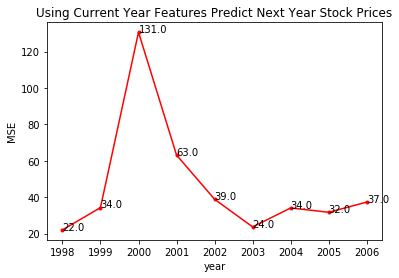

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

year = mes_dict.keys()
mse = mes_dict.values()
plt.plot(year,mse,'.-r')
plt.xlabel('year')
plt.ylabel('MSE')
plt.title('Using Current Year Features Predict Next Year Stock Prices')
for xy in zip(year, mse):                                       # <--
    ax.annotate('%s' % round(xy[1],0),xy = xy, textcoords='data')


In [156]:
xy[0]

1998